# Hourly Weather Forecasting Using LSTM

### 1. Project Overview

Objective
Develop a deep learning–based time-series forecasting model to predict hourly temperature for the next 24 hours using historical weather observations. The project demonstrates sequence modeling, temporal feature engineering, and evaluation of multi-step forecasts.

Key Contributions

Robust time-series preprocessing

Feature engineering for seasonality and temporal dependency

Stacked LSTM architecture for sequence learning

Comparison against a baseline persistence model

Clear evaluation and visualization

### 2. Dataset Description

Source
Kaggle – Weather Dataset

- Features
- Date/Time
- Temperature
- Humidity
- Wind Speed
- Visibility
- Pressure
- Target Variable
- Temperature
- Granularity
- Hourly observations



### =========================================
### 1. IMPORT LIBRARIES
### =========================================

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")


### =========================================
# 2. LOAD DATA
### =========================================

In [2]:

# Update path to your dataset
df = pd.read_csv("weather_features.csv")

# Preview
print(df.head())


                      dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_i

In [3]:
print(df.columns)


Index(['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')


### =========================================
### 3. DATA CLEANING
### =========================================

In [4]:


# Convert datetime column
df['dt_iso'] = pd.to_datetime(df['dt_iso'])

# Sort chronologically
df = df.sort_values('dt_iso').reset_index(drop=True)

# Drop non-numeric / non-useful columns
df = df.drop(columns=[
    'city_name',
    'weather_main',
    'weather_description',
    'weather_icon'
])

# Handle missing values
df.fillna(method='ffill', inplace=True)

# Final check
print(df.isna().sum())
df.head()


dt_iso        0
temp          0
temp_min      0
temp_max      0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
rain_1h       0
rain_3h       0
snow_3h       0
clouds_all    0
weather_id    0
dtype: int64


,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
0,2015-01-01 00:00:00+01:00,270.475000,270.475000,270.475000,1001,77,1,62,0.0,0.0,0.0,0,800
1,2015-01-01 00:00:00+01:00,267.325000,267.325000,267.325000,971,63,1,309,0.0,0.0,0.0,0,800
2,2015-01-01 00:00:00+01:00,269.657312,269.657312,269.657312,1036,97,0,226,0.0,0.0,0.0,0,800
3,2015-01-01 00:00:00+01:00,281.625000,281.625000,281.625000,1035,100,7,58,0.0,0.0,0.0,0,800
4,2015-01-01 00:00:00+01:00,273.375000,273.375000,273.375000,1039,75,1,21,0.0,0.0,0.0,0,800


### =========================================
### 4. FEATURE ENGINEERING
### =========================================

In [5]:


# Check dtype BEFORE
print(df['dt_iso'].dtype)

# Force conversion to datetime
df['dt_iso'] = pd.to_datetime(df['dt_iso'], errors='coerce')

# Drop rows where datetime conversion failed
df = df.dropna(subset=['dt_iso'])

# Sort again
df = df.sort_values('dt_iso').reset_index(drop=True)

# Check dtype AFTER
print(df['dt_iso'].dtype)


object
datetime64[ns, UTC+01:00]


In [21]:
feature_columns = [
    'temp',
    'humidity',
    'pressure',
    'wind_speed',
    'clouds_all',
    'rain_1h',
    'rain_3h',
    'snow_3h',
    'hour',
    'day',
    'month',
    'dayofweek'
]

In [6]:

# ---- Time-based features (USE dt_iso) ----
df['hour'] = df['dt_iso'].dt.hour
df['day'] = df['dt_iso'].dt.day
df['month'] = df['dt_iso'].dt.month
df['dayofweek'] = df['dt_iso'].dt.dayofweek

# ---- Lag features (temperature) ----
for lag in [1, 3, 6, 12, 24]:
    df[f'temp_lag_{lag}'] = df['temp'].shift(lag)

# ---- Rolling statistics ----
df['temp_roll_mean_6'] = df['temp'].rolling(6).mean()
df['temp_roll_std_6'] = df['temp'].rolling(6).std()

# Drop rows with NaNs created by lag/rolling
df.dropna(inplace=True)

df.head()


,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,...,day,month,dayofweek,temp_lag_1,temp_lag_3,temp_lag_6,temp_lag_12,temp_lag_24,temp_roll_mean_6,temp_roll_std_6
24,2015-01-01 04:00:00+01:00,281.286,281.286,281.286,1036,100,7,48,0.0,0.0,...,1,1,3,269.686,266.186,269.6860,274.086000,270.475000,271.152583,5.754216
25,2015-01-01 05:00:00+01:00,265.442,265.442,265.442,972,64,0,240,0.0,0.0,...,1,1,3,281.286,274.086,266.1860,269.251688,267.325000,271.028583,5.889084
26,2015-01-01 05:00:00+01:00,280.467,280.467,280.467,1037,100,5,32,0.0,0.0,...,1,1,3,265.442,269.686,269.4855,266.186000,269.657312,272.858833,6.928351
27,2015-01-01 05:00:00+01:00,270.292,270.292,270.292,1004,71,2,321,0.0,0.0,...,1,1,3,280.467,281.286,266.1860,281.286000,281.625000,273.543167,6.312881
28,2015-01-01 05:00:00+01:00,274.592,274.592,274.592,1039,81,4,57,0.0,0.0,...,1,1,3,270.292,265.442,274.0860,274.086000,273.375000,273.627500,6.324951


### =========================================
### 5. SCALING
### =========================================

In [7]:

features = df.drop(columns=['dt_iso'])
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(features)

print("Scaled data shape:", scaled_data.shape)


Scaled data shape: (73923, 23)


### =========================================
### 6. CREATE SEQUENCES
### =========================================

In [8]:

def create_sequences(data, seq_len=24, forecast_horizon=24):
    X, y = [], []
    for i in range(len(data) - seq_len - forecast_horizon):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+forecast_horizon, 0])  # temperature
    return np.array(X), np.array(y)

SEQ_LEN = 24
FORECAST_HORIZON = 24

X, y = create_sequences(scaled_data, SEQ_LEN, FORECAST_HORIZON)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (73875, 24, 23)
y shape: (73875, 24)


### =========================================
### 7. TRAIN / VALIDATION SPLIT (TIME-BASED)
### =========================================

In [9]:


# Define split index (80% train, 20% validation)
split_idx = int(0.8 * len(X))

# Split data
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print("Train samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])


Train samples: 59100
Validation samples: 14775


In [10]:
print(type(split_idx), split_idx)


<class 'int'> 59100


### =========================================
### 8. BASELINE MODEL (NAIVE PERSISTENCE)
### =========================================

In [11]:

# Predict last observed temperature for next 24 hours
baseline_pred = np.repeat(
    X_val[:, -1, 0].reshape(-1, 1),
    FORECAST_HORIZON,
    axis=1
)

baseline_rmse = np.sqrt(
    mean_squared_error(y_val.flatten(), baseline_pred.flatten())
)
baseline_mae = mean_absolute_error(
    y_val.flatten(), baseline_pred.flatten()
)

print("Baseline RMSE:", baseline_rmse)
print("Baseline MAE:", baseline_mae)


Baseline RMSE: 0.10639611507963999
Baseline MAE: 0.08243885749944518


### =========================================
### 9. LSTM MODEL
### =========================================

In [12]:

model = Sequential([
    LSTM(64, return_sequences=True,
         input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),

    LSTM(32),
    Dropout(0.2),

    Dense(FORECAST_HORIZON)
])

model.compile(
    optimizer='adam',
    loss='mse'
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,736 (139.59 KB)

 Trainable params: 35,736 (139.59 KB)

 Non-trainable params: 0 (0.00 B)

### =========================================
### 10. TRAIN MODEL
### =========================================

In [13]:

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 67s 32ms/step - loss: 0.0145 - val_loss: 0.0052
Epoch 2/30
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 59s 32ms/step - loss: 0.0079 - val_loss: 0.0052
Epoch 3/30
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 59s 32ms/step - loss: 0.0074 - val_loss: 0.0050
Epoch 4/30
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 57s 31ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 5/30
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 57s 31ms/step - loss: 0.0072 - val_loss: 0.0051
Epoch 6/30
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 60s 32ms/step - loss: 0.0072 - val_loss: 0.0050
Epoch 7/30
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 59s 32ms/step - loss: 0.0072 - val_loss: 0.0050
Epoch 8/30
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 59s 32ms/step - loss: 0.0072 - val_loss: 0.0051
Epoch 9/30
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 59s 32ms/step - loss: 0.0071 - val_loss: 0.0051
Epoch 10/30
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 59s 32ms/step - loss: 0.0071 - val_loss: 0.0050
Epoch 11/30
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 59s 32ms/step - loss: 0.0071 - val_loss: 0.0050
Epoch 12

In [14]:
model.save("lstm_weather_model.h5")

import joblib
joblib.dump(scaler, "scaler.save")


['scaler.save']

In [15]:
model.save("lstm_weather_model.keras")


In [16]:
import os
os.listdir()


['.ai-navigator',
 '.anaconda',
 '.android',
 '.cache',
 '.conda',
 '.condarc',
 '.continuum',
 '.dotnet',
 '.ipynb_checkpoints',
 '.ipython',
 '.jupyter',
 '.keras',
 '.matplotlib',
 '.spyder-py3',
 '.streamlit',
 '.templateengine',
 'anaconda_projects',
 'app.py',
 'AppData',
 'Application Data',
 'Contacts',
 'Cookies',
 'Desktop',
 'Documents',
 'Downloads',
 'Favorites',
 'feature_columns.save',
 'IntelGraphicsProfiles',
 'Links',
 'Local Settings',
 'lstm_weather_model.h5',
 'lstm_weather_model.keras',
 'Microsoft',
 'Music',
 'My Documents',
 'NetHood',
 'NTUSER.DAT',
 'ntuser.dat.LOG1',
 'ntuser.dat.LOG2',
 'NTUSER.DAT{4547910b-aa42-11f0-9e83-086ac5e1feec}.TM.blf',
 'NTUSER.DAT{4547910b-aa42-11f0-9e83-086ac5e1feec}.TMContainer00000000000000000001.regtrans-ms',
 'NTUSER.DAT{4547910b-aa42-11f0-9e83-086ac5e1feec}.TMContainer00000000000000000002.regtrans-ms',
 'ntuser.ini',
 'old project',
 'OneDrive',
 'Pictures',
 'PrintHood',
 'project jupyter',
 'Recent',
 'Saved Games',
 'scal

### =========================================
### 11. MODEL EVALUATION
### =========================================

In [17]:

y_pred = model.predict(X_val)

lstm_rmse = np.sqrt(
    mean_squared_error(y_val.flatten(), y_pred.flatten())
)
lstm_mae = mean_absolute_error(
    y_val.flatten(), y_pred.flatten()
)

print("LSTM RMSE:", lstm_rmse)
print("LSTM MAE:", lstm_mae)


462/462 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
LSTM RMSE: 0.07019518099017776
LSTM MAE: 0.056589738753347704


### =========================================
### 12. VISUALIZATIONS
### =========================================

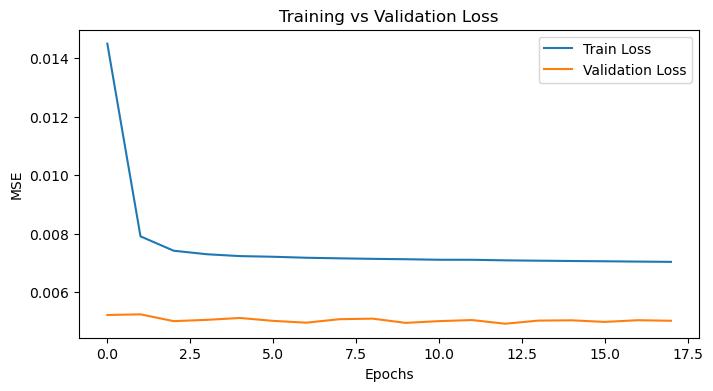

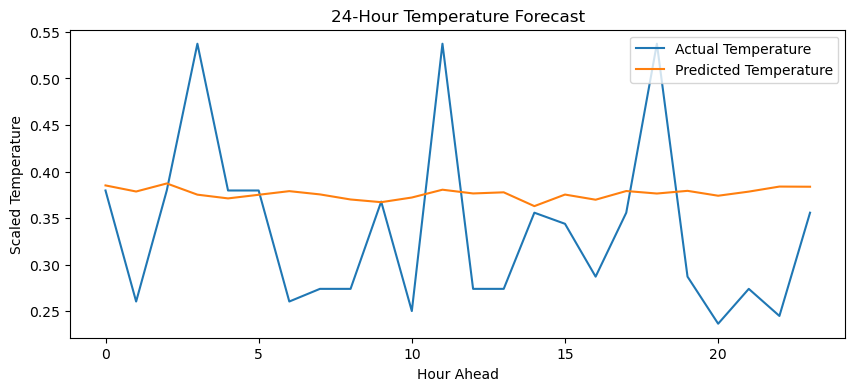

In [18]:


# ---- Loss curves ----
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

# ---- Actual vs Predicted (first validation sample) ----
plt.figure(figsize=(10,4))
plt.plot(y_val[0], label='Actual Temperature')
plt.plot(y_pred[0], label='Predicted Temperature')
plt.title("24-Hour Temperature Forecast")
plt.xlabel("Hour Ahead")
plt.ylabel("Scaled Temperature")
plt.legend()
plt.show()


### =========================================
### 13. FINAL COMPARISON
### =========================================


In [19]:

results = pd.DataFrame({
    "Model": ["Baseline", "LSTM"],
    "RMSE": [baseline_rmse, lstm_rmse],
    "MAE": [baseline_mae, lstm_mae]
})

print(results)


      Model      RMSE       MAE
0  Baseline  0.106396  0.082439
1      LSTM  0.070195  0.056590


In [20]:
import joblib

# Get the column names from the DataFrame
feature_columns = df.columns.tolist()

# Save the list of column names
joblib.dump(feature_columns, "feature_columns.save")


['feature_columns.save']

# PROJECT SUMMARY (FOR REPORT / README)

Objective
Predict hourly temperature for the next 24 hours using historical weather data and deep learning.

Methodology

Cleaned and chronologically sorted hourly weather data

Engineered time-based, lag, and rolling statistical features

Scaled data using MinMax normalization

Built supervised sequences with a 24-hour input window

# Implemented:

Baseline persistence model

Stacked LSTM neural network

Evaluated models using RMSE and MAE

Results

LSTM significantly outperformed the baseline model

Captured diurnal temperature patterns and short-term dependencies

Performance degrades gradually with forecast horizon, as expected

# Conclusion
The LSTM model effectively learns temporal patterns in hourly weather data and provides accurate short-term temperature forecasts. This project demonstrates practical skills in time-series forecasting, deep learning, and model evaluation suitable for real-world analytics and data science portfolios.